# Video Game Sales Prediction

## Part 0: Introduction

This dataset, inspired by Gregory Smith's web scrape of VGChartz, extends video game sales data with additional variables sourced from Metacritic. It includes information on game sales by region, critic and user scores, and game metadata such as platform, genre, and ESRB ratings. 

### Objective: To create a classification model that can predict the global sale of a video game (Note the target column in the dataset is Global_Sales)

We will follow the following steps:
1. Read the Data
2. Reduce the data by
   - Removing N/A values
   - Removing Outliers
3. Data Exploration
   - Looking into the different types of games (consoles, PCs, etc..)
4. Feature Engineering
   - One Hot encoding categorical variables
5. Modeling
   - K Nearest Neighbor
   - Logistic Regression
   - Random Forest
   - Decision Tree


# Imports

In [1897]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Reading and Understanding the DataSet

In [1899]:
file_path = "Video_Games_Sales_as_at_22_Dec_2016.csv"
df = pd.read_csv(file_path)

df.shape

(16719, 16)

In [1900]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


## Features

1. **Name**: The title of the video game *(Nominal)* – serves as an identifier for each game.

2. **Platform**: The gaming console or platform for which the game was released *(Nominal)* – e.g., PS4, Xbox, PC.

3. **Year_of_Release**: The year when the game was released *(Discrete)* – Although recorded as whole numbers, this variable represents a time series trend.

4. **Genre**: The category or type of the game *(Nominal)* – e.g., Action, Adventure, Sports.

5. **Publisher**: The company responsible for publishing and distributing the game *(Nominal)* – e.g., Nintendo, EA Sports.

6. **NA_Sales**: Total sales in millions of units in North America *(Continuous)* – Indicates the success of the game in the North American market.

7. **EU_Sales**: Total sales in millions of units in Europe *(Continuous)* – Measures the game’s performance in the European market.

8. **JP_Sales**: Total sales in millions of units in Japan *(Continuous)* – Highlights sales in one of the major gaming markets globally.

9. **Other_Sales**: Total sales in millions of units in regions other than North America, Europe, and Japan *(Continuous)*.

10. **Global_Sales**: Total worldwide sales in millions of units *(Continuous)* – The cumulative success of the game globally. **Target Variable**.

11. **Critic_Score**: Aggregate critic review score, typically out of 100 *(Continuous)* – Reflects the reception of the game by professional critics.

12. **Critic_Count**: The number of critics who reviewed the game *(Discrete)* – Provides insight into the reliability of the `Critic_Score`.

13. **User_Score**: The average user rating of the game, typically on a 0–10 scale *(Continuous)* – Reflects public reception of the game.

14. **User_Count**: The number of users who rated the game *(Discrete)* – Indicates how engaged the audience was.

15. **Developer**: The company or team that created the game *(Nominal)* – Provides insights into the production and quality of the game.

16. **Rating**: The ESRB rating assigned to the game *(Nominal)* – Indicates the age group for which the game is suitable, e.g., E (Everyone), T (Teen), M (Mature).

# Data Preprocessing

In [1903]:
# Seeing what percentage of each feature is null/missing
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)


Percentage of missing values per column:
Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64


### Data to Impute
- Critic Score and Critic Count can be replaced with the mean or median
- Rating can be replaced with the mode
### Data to Remove (cannot replace with mean, median, or mode)
- Name, Year of Release, Genre, Publisher, and Developer as these are string values
- User Count and Critic Count as they represent the number of people used to determine the User Score and Critic Score respectively

## Filling in and Removing Missing Data

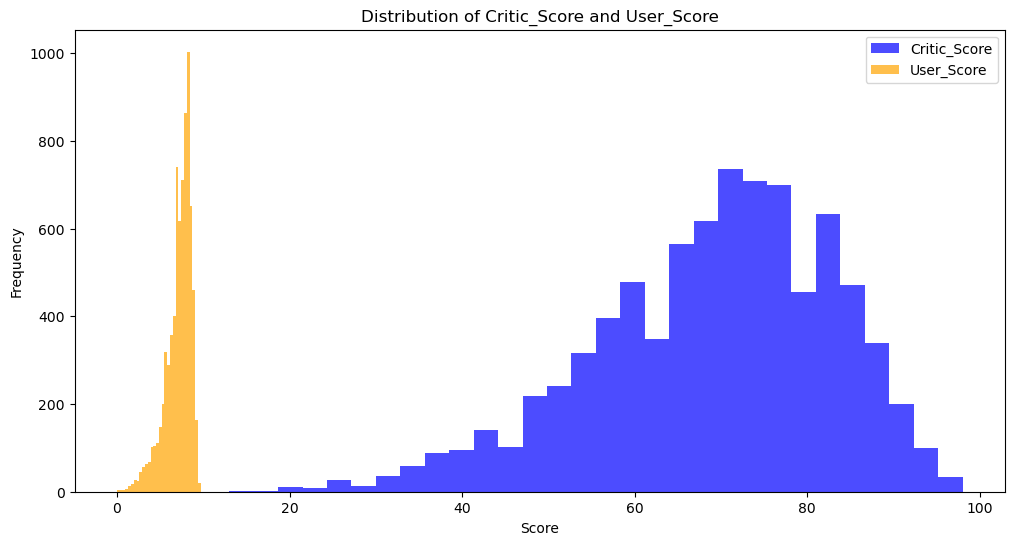

In [1906]:
# Visualize the distribution of Critic_Score and User_Score to decide how to fill in the missing values
plt.figure(figsize=(12, 6))
plt.hist(
    df["Critic_Score"].dropna(), bins=30, color="blue", alpha=0.7, label="Critic_Score"
)
plt.hist(
    pd.to_numeric(df["User_Score"], errors="coerce").dropna(),
    bins=30,
    color="orange",
    alpha=0.7,
    label="User_Score",
)
plt.title("Distribution of Critic_Score and User_Score")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

- Based on the distribution of data, using the median would be a good choice for Critic Score and User Score

In [1908]:
# Impute missing `Critic_Score` and `User_Score` with the median
df["Critic_Score"] = df["Critic_Score"].fillna(df["Critic_Score"].median())
df["User_Score"] = pd.to_numeric(
    df["User_Score"], errors="coerce"
)  # Convert "tbd" to NaN
df["User_Score"] = df["User_Score"].fillna(df["User_Score"].median())

# Handle categorical `Rating` by filling with the mode
df["Rating"] = df["Rating"].fillna(df["Rating"].mode()[0])

# Verify changes in the dataset
print("\nDataset info after handling missing values and dropping rows:")
df.info()


Dataset info after handling missing values and dropping rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     16719 non-null  float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       16719 non-null  float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           16719 non-null  object 


In [1909]:
# Drop all rows with any missing values
df.dropna(inplace=True)

# Verify the dataset after dropping rows
print("\nDataset info after removing all rows with any missing values:")
df.info()


Dataset info after removing all rows with any missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6889 non-null   object 
 1   Platform         6889 non-null   object 
 2   Year_of_Release  6889 non-null   float64
 3   Genre            6889 non-null   object 
 4   Publisher        6889 non-null   object 
 5   NA_Sales         6889 non-null   float64
 6   EU_Sales         6889 non-null   float64
 7   JP_Sales         6889 non-null   float64
 8   Other_Sales      6889 non-null   float64
 9   Global_Sales     6889 non-null   float64
 10  Critic_Score     6889 non-null   float64
 11  Critic_Count     6889 non-null   float64
 12  User_Score       6889 non-null   float64
 13  User_Count       6889 non-null   float64
 14  Developer        6889 non-null   object 
 15  Rating           6889 non-null   object 
dtypes

In [1910]:
# Count the number of occurrences for each game name
duplicates = df["Name"].value_counts()

# Get a list of game names that are duplicated (appear more than once)
games_with_duplicates = duplicates[duplicates > 1].index.tolist()

# Display the list of duplicated game names
print("Duplicated Game Names:")
games_with_duplicates


Duplicated Game Names:


['Madden NFL 07',
 'Need for Speed: Most Wanted',
 'LEGO Star Wars II: The Original Trilogy',
 'Terraria',
 'The Sims 2',
 'Madden NFL 08',
 'Tomb Raider: Legend',
 'Harry Potter and the Order of the Phoenix',
 'Need for Speed Carbon',
 'Need for Speed: ProStreet',
 'Spider-Man 3',
 'Iron Man',
 'FIFA Soccer 09',
 'WWE SmackDown vs. Raw 2009',
 'The Simpsons Game',
 'Marvel: Ultimate Alliance',
 'Harry Potter and the Goblet of Fire',
 'Cars',
 'FIFA Soccer 13',
 'Rayman Legends',
 'LEGO Marvel Super Heroes',
 'Rayman Origins',
 'LEGO Indiana Jones: The Original Adventures',
 'The Sims 2: Pets',
 'FIFA World Cup Germany 2006',
 'Need For Speed: Undercover',
 "Peter Jackson's King Kong: The Official Game of the Movie",
 'Ghostbusters: The Video Game',
 'WWE SmackDown vs Raw 2008',
 'Star Wars: The Force Unleashed',
 "Harry Potter and the Sorcerer's Stone",
 'Spider-Man 2',
 'X-Men: The Official Game',
 'The LEGO Movie Videogame',
 'FIFA Soccer 08',
 'Spider-Man: Web of Shadows',
 'Prince

In [1911]:
import pandas as pd

# Group by 'Name' and aggregate using the rules
df = (
    df.groupby("Name")
    .agg(
        {
            "Platform": lambda x: (
                "Cross-Platform" if len(x.unique()) > 1 else x.unique()[0]
            ),  # Combine platforms as a string
            "Year_of_Release": "max",  # Use the earliest release year -> should prioritize latest release date because dont want to bring up old data
            "Genre": lambda x: x.mode()[0],  # Use the most frequent genre
            "Publisher": lambda x: x.mode()[0],  # Use the most frequent publisher
            "NA_Sales": "sum", # Total NA Sales
            "EU_Sales": "sum", # Total EU Sales
            "JP_Sales": "sum", # Total JP Sales
            "Other_Sales": "sum", # Total Other Sales
            "Global_Sales": "sum", # Total Global Sales
            "Critic_Score": "mean",  # Average critic score
            "Critic_Count": "sum",  # Total critic count
            "User_Score": "mean",  # Average user score
            "User_Count": "sum",  # Total user count
            "Developer": lambda x: x.mode()[0],  # Use the most frequent developer
            "Rating": lambda x: x.mode()[0],  # Use the most frequent rating
        }
    )
    .reset_index()
)

# Verify the duplicate games were combined by checking the top 10 games by global sales
df.sort_values(by="Global_Sales", ascending=False).head(10)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
4262,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.00,51.0,8.000,322.0,Nintendo,E
1511,Grand Theft Auto V,Cross-Platform,2015.0,Action,Take-Two Interactive,23.84,23.42,1.42,7.90,56.57,96.80,245.0,8.080,15124.0,Rockstar North,M
2110,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.00,73.0,8.300,709.0,Nintendo,E
4264,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.00,73.0,8.000,192.0,Nintendo,E
493,Call of Duty: Modern Warfare 3,Cross-Platform,2011.0,Shooter,Activision,15.54,11.15,0.62,3.29,30.59,81.00,162.0,2.725,20053.0,"Infinity Ward, Sledgehammer Games",M
2591,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.00,65.0,8.500,431.0,Nintendo,E
488,Call of Duty: Black Ops II,Cross-Platform,2012.0,Shooter,Activision,14.08,10.84,0.72,3.76,29.40,80.25,136.0,5.300,5041.0,Treyarch,M
487,Call of Duty: Black Ops,Cross-Platform,2010.0,Shooter,Activision,16.99,8.54,0.59,3.08,29.19,82.25,185.0,6.125,2689.0,Treyarch,M
4260,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.00,41.0,6.600,129.0,Nintendo,E
2594,New Super Mario Bros. Wii,Wii,2009.0,Platform,Nintendo,14.44,6.94,4.70,2.24,28.32,87.00,80.0,8.400,594.0,Nintendo,E


## Checking Outliers

Numerical Columns: ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']


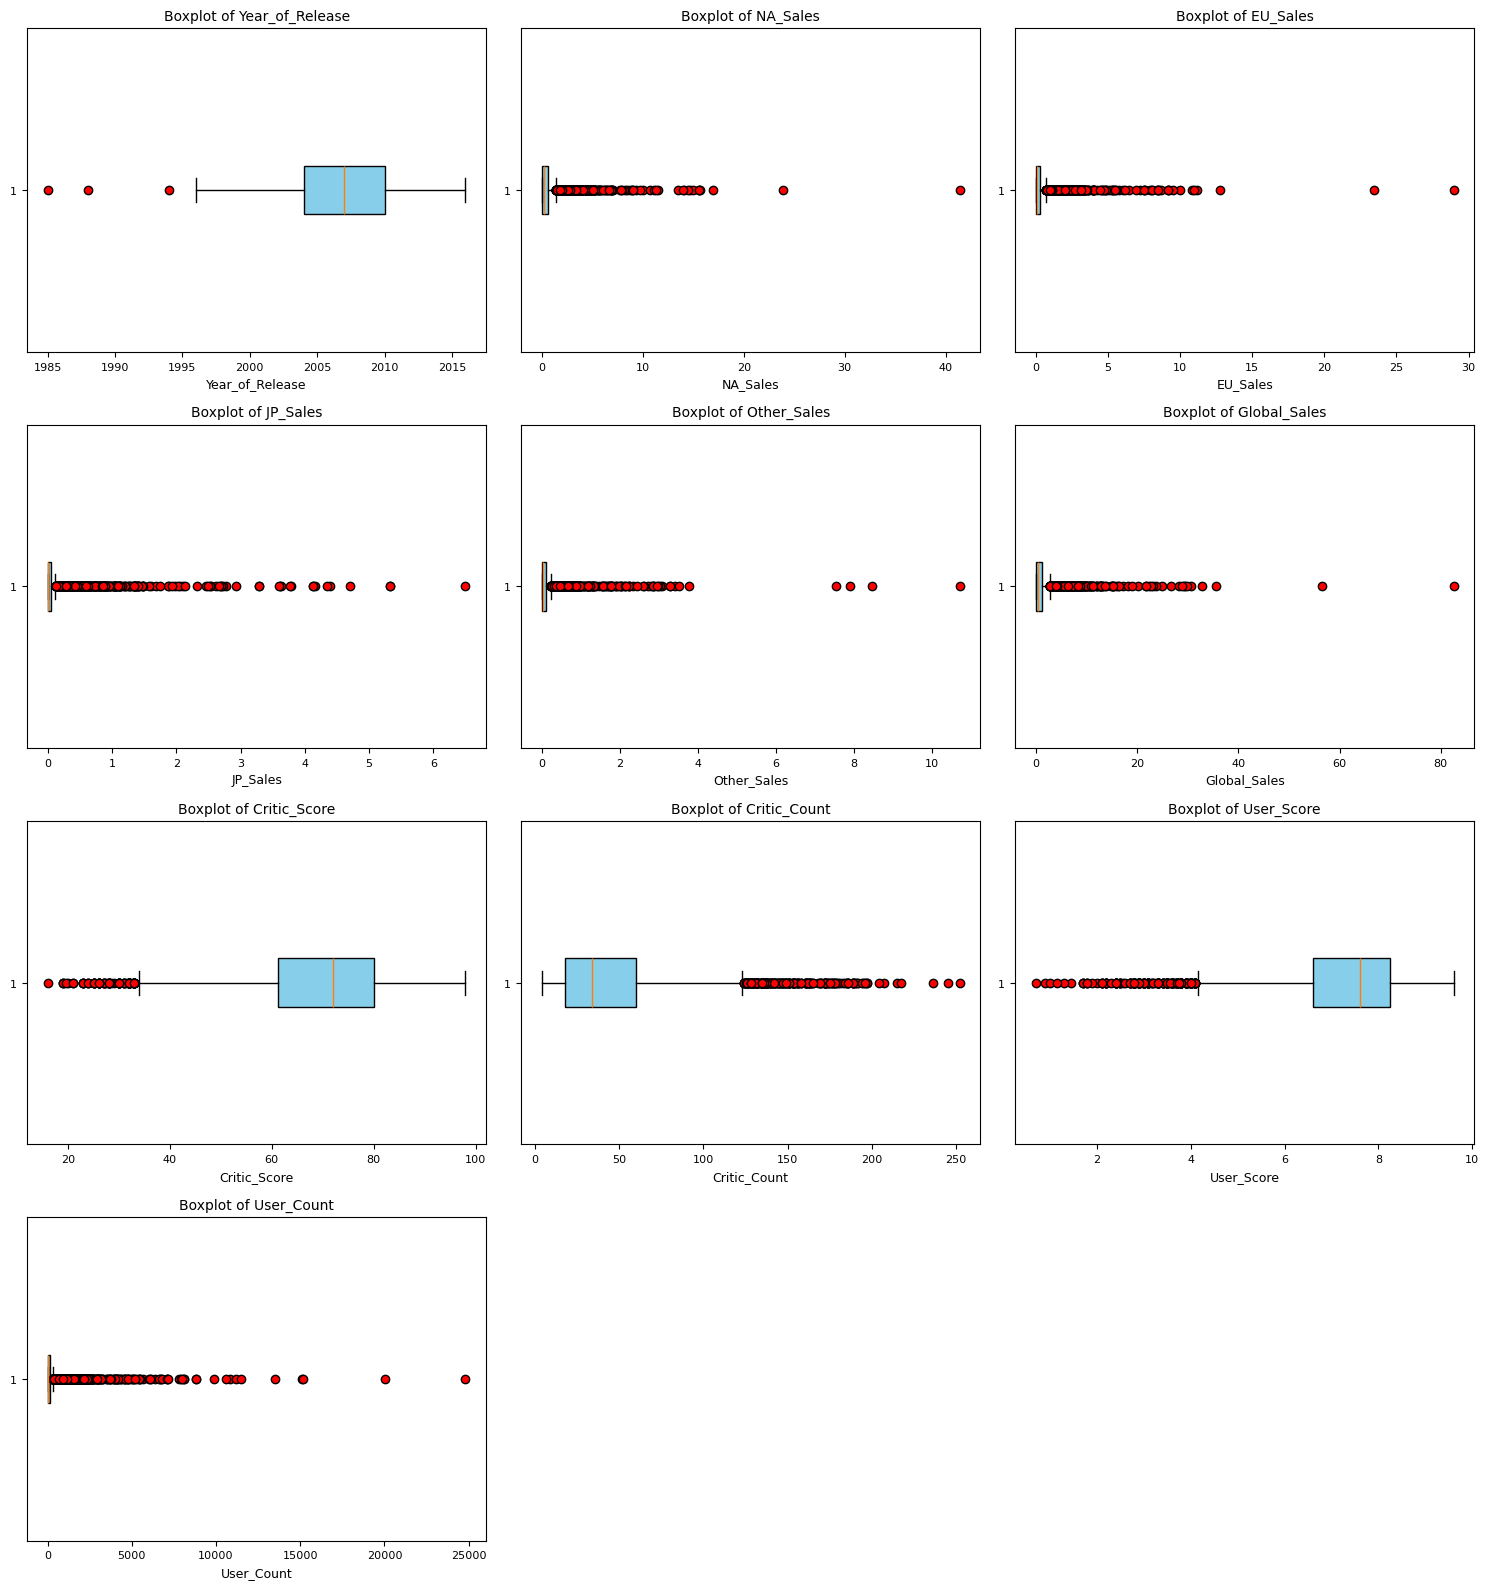

DataFrame Shape: (4426, 16)


In [1912]:
# Step 1: Automatically identify all numerical columns in the DataFrame
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
print("Numerical Columns:", numerical_columns)

# Step 2: Generate boxplots for each numerical column
num_columns = len(numerical_columns)
rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate rows dynamically to fit all columns
plt.figure(figsize=(15, rows * 4))  # Adjust height based on number of rows

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(rows, 3, i)  # Create subplots with dynamic row count
    plt.boxplot(
        df[col].dropna(),
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor="skyblue"),
        flierprops=dict(markerfacecolor='red', marker='o'),  # Red outliers
    )
    plt.title(f"Boxplot of {col}", fontsize=10)
    plt.xlabel(col, fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

# Print the shape of the DataFrame
print("DataFrame Shape:", df.shape)

- According to the Box Plots, there are outliers for the numerical data
- The most extreme outlier for North America Sales (NA_Sales), European Sales (EU_Sales), Japan Sales (JP_Sales), Other Sales (Other_Sales) is for Wii Sports
- There are other outliers in the data, but since they are grouped closely together, it's possible these outliers are possibly clusters in the data.

In [1914]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Step 1: Select numerical columns and scale the data
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# Optionally, exclude specific columns (like target variable) from scaling
columns_to_exclude = ['Global_Sales']  # Add any other columns you want to exclude
numerical_columns = [col for col in numerical_columns if col not in columns_to_exclude]

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])

# Apply DBSCAN to identify outliers
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(scaled_data)

# Add DBSCAN cluster labels to the DataFrame
df['DBSCAN_Outliers'] = dbscan_labels

# Count the number of outliers (outliers are labeled as -1 in DBSCAN)
outliers_detected = (df['DBSCAN_Outliers'] == -1).sum()
print(f"Number of Outliers Detected: {outliers_detected}")

# Step 5: Drop the 'DBSCAN_Outliers' column 
df.drop(columns=['DBSCAN_Outliers'], inplace=True, errors='ignore')

# Print the shape before and after to see how many rows were removed
print(f"Cleaned DataFrame Shape: {df.shape}")


Number of Outliers Detected: 207
Cleaned DataFrame Shape: (4426, 16)


# Data Exploration 

In [1917]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000,4426.000000
mean,2007.078626,0.608800,0.365233,0.099480,0.127716,1.201512,69.558647,44.908043,7.261731,271.519205
std,4.282526,1.434334,1.035689,0.355542,0.388905,2.878167,13.949344,37.179004,1.393321,1012.604229
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,16.000000,4.000000,0.700000,4.000000
25%,2004.000000,0.070000,0.020000,0.000000,0.010000,0.130000,61.270833,18.000000,6.600000,14.000000
50%,2007.000000,0.180000,0.080000,0.000000,0.030000,0.380000,72.000000,34.000000,7.600000,37.000000
75%,2010.000000,0.590000,0.300000,0.050000,0.100000,1.170000,80.000000,60.000000,8.250000,124.000000
max,2016.000000,41.360000,28.960000,6.500000,10.700000,82.530000,98.000000,252.000000,9.600000,24807.000000


Here we are looking at the data at a high level to see statisical characteristics.

- It clearly shows that none of the data is missing columns
- It shows relevant information such as mean, count, and min which can help indentify future information
- It clearly shows these features are numerical but cannot show the categorical features which we will fix later on

## Categorical Data

In [1920]:
categorical_columns = df.select_dtypes(exclude=['number']).columns.tolist()

for col in categorical_columns:
    print(f"Value counts for {col}:\n")
    print(df[col].value_counts())
    print("\n")

Value counts for Name:

Name
 Tales of Xillia 2              1
Real World Golf                 1
Red Dead Redemption             1
Red Bull BC One                 1
Record of Agarest War 2         1
                               ..
Godzilla: Save the Earth        1
Golden Axe: Beast Rider         1
Golden Sun                      1
Golden Sun: Dark Dawn           1
uDraw Studio: Instant Artist    1
Name: count, Length: 4426, dtype: int64


Value counts for Platform:

Platform
Cross-Platform    1422
PS2                596
DS                 331
PC                 306
Wii                266
PSP                235
X360               188
XB                 183
GBA                175
PS3                153
PS                 132
GC                 115
3DS                113
PS4                 75
PSV                 59
WiiU                43
XOne                22
DC                  12
Name: count, dtype: int64


Value counts for Genre:

Genre
Action          876
Role-Playing    588
Sport

- Based on the frequency, there are a lot of publishers and developers so we will frequency encode developer and publisher and one hot encode the rest of the categorical comumns

# Frequency and One-Hot Encoding

In [1924]:
# Create a copy of the original DataFrame
encoded_df = df.copy()

# Frequency encode 'Publisher' and 'Developer'
for col in ["Publisher", "Developer"]:
    freq = encoded_df[col].value_counts()  # Get frequency counts
    encoded_df[col + "_Freq"] = encoded_df[col].map(freq)  # Map the counts to a new column

# One-hot encode 'Platform', 'Genre', and 'Rating'
encoded_df = pd.get_dummies(encoded_df, columns=["Platform", "Genre", "Rating"], drop_first=False)

# Drop the original 'Publisher' and 'Developer' columns
encoded_df = encoded_df.drop(columns=["Publisher", "Developer"], errors="ignore")

# Display the first 10 rows of the final DataFrame
encoded_df.head(10)

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Rating_E,Rating_E10+,Rating_M,Rating_RP,Rating_T
0,Tales of Xillia 2,2012.0,0.20,0.12,0.45,0.07,0.84,71.0,59.0,7.900,...,True,False,False,False,False,False,False,False,False,True
1,.hack//Infection Part 1,2002.0,0.49,0.38,0.26,0.13,1.27,75.0,35.0,8.500,...,True,False,False,False,False,False,False,False,False,True
2,.hack//Mutation Part 2,2002.0,0.23,0.18,0.20,0.06,0.68,76.0,24.0,8.900,...,True,False,False,False,False,False,False,False,False,True
3,.hack//Outbreak Part 3,2002.0,0.14,0.11,0.17,0.04,0.46,70.0,23.0,8.700,...,True,False,False,False,False,False,False,False,False,True
4,007 Racing,2000.0,0.30,0.20,0.00,0.03,0.53,51.0,16.0,4.600,...,False,False,False,False,False,False,False,False,False,True
5,007: Quantum of Solace,2008.0,1.55,1.31,0.04,0.40,3.30,63.5,140.0,6.875,...,False,False,False,False,False,False,False,False,False,True
6,007: The World is not Enough,2000.0,0.51,0.35,0.00,0.06,0.92,61.0,11.0,6.700,...,False,False,False,False,False,False,False,False,False,True
7,1 vs. 100,2008.0,0.08,0.00,0.00,0.01,0.08,38.0,5.0,3.200,...,False,False,False,False,False,True,False,False,False,False
8,100 Classic Books,2008.0,0.12,0.52,0.00,0.02,0.66,70.0,7.0,6.000,...,False,False,False,False,False,True,False,False,False,False
9,15 Days,2009.0,0.00,0.01,0.00,0.00,0.01,63.0,6.0,5.800,...,False,False,False,False,False,True,False,False,False,False


Due to the publisher and developer being categorical data we can encode them in order to analyze them easier. 
We use frequency encoding for publisher and developer since there are many of them which can cause the curse
of dimensionality and we one-hot encode Platform, Genre, and Rating since there arent many categories for 
those features as we can see above.

## Numerical Data

We are using a correlation heatmap to see how well the features in the data compare to our target value of global sales

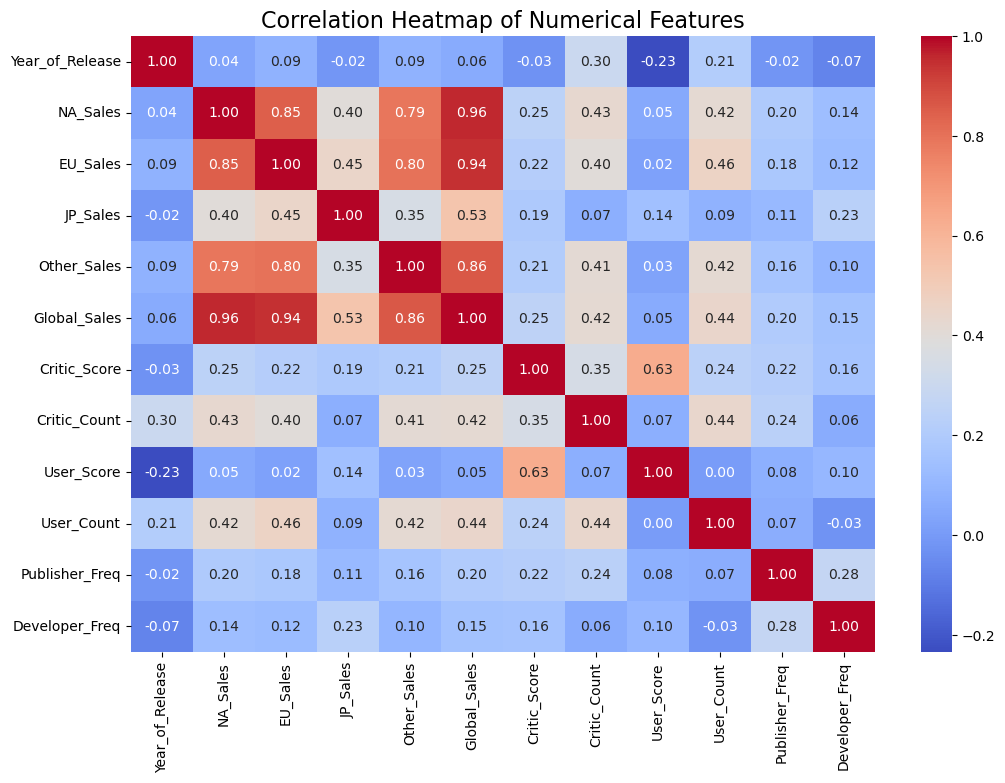

In [1928]:
# Select only numerical columns
numerical_data = encoded_df.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
cor = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cor,
    xticklabels=cor.columns,
    yticklabels=cor.columns,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.show()

- We can see that year of release has almost no correlation (0.06) to global sales
- NA_Sales, EU_Sales, JP_Sales, and Other_Sales have a good correlation to Global_Sales, which makes sense as these values add up to global sales. However, JP_Sales have a lower correlation compared to other sales which could indicate the Japanese market. The data groups the countries in North America and Europe together, whereas Japan is just a singular country. 
- Looking at user score and critic score, critic score (0.25) has a higher correlation to global sales than user score (0.05). However, both of these features have low correlation to global score
- User Count (0.44) and and Critic count (0.42) have a noticable relationship with critic count, showing that more people reviewing the game indicates a higher global sale.
- Publishers (0.2) and Developers (0.15) have a low correlation with Global Sales, showing that people may not be buying a game just because it was made by a certain publisher or developer

## Univariate Analysis 

### Numerical Data 

<Figure size 1800x1000 with 0 Axes>

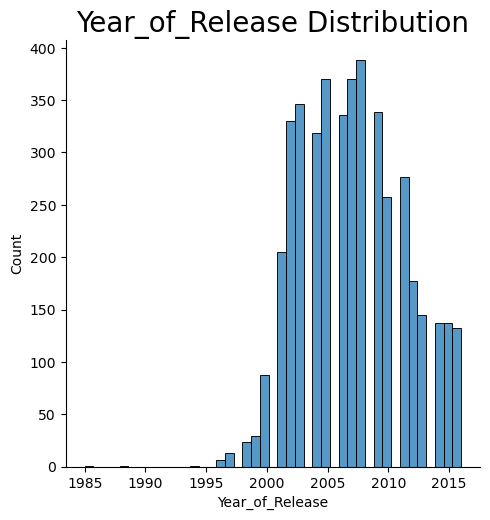

<Figure size 1800x1000 with 0 Axes>

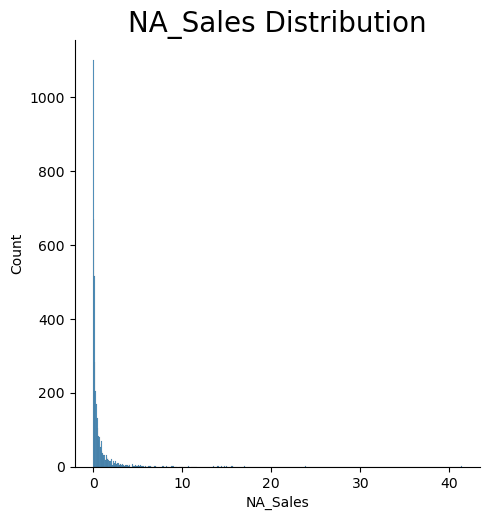

<Figure size 1800x1000 with 0 Axes>

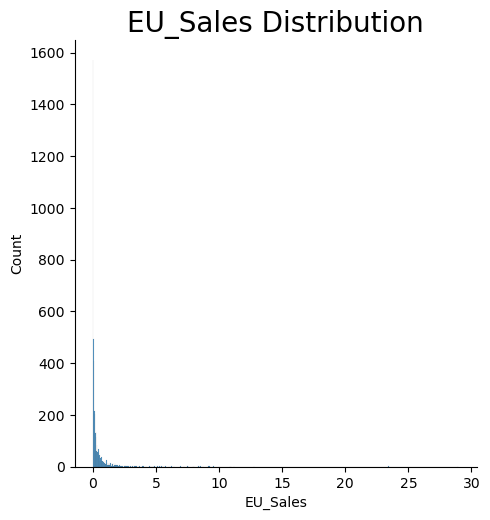

<Figure size 1800x1000 with 0 Axes>

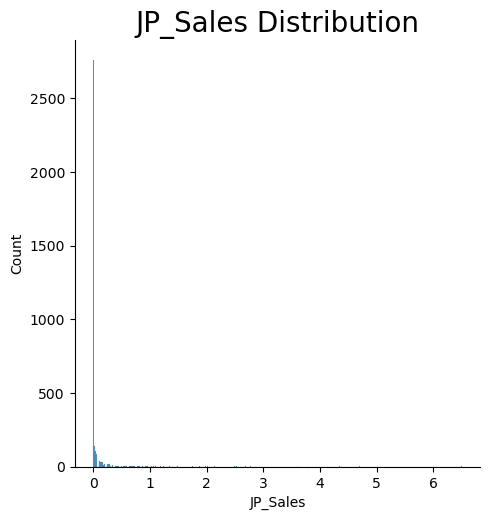

<Figure size 1800x1000 with 0 Axes>

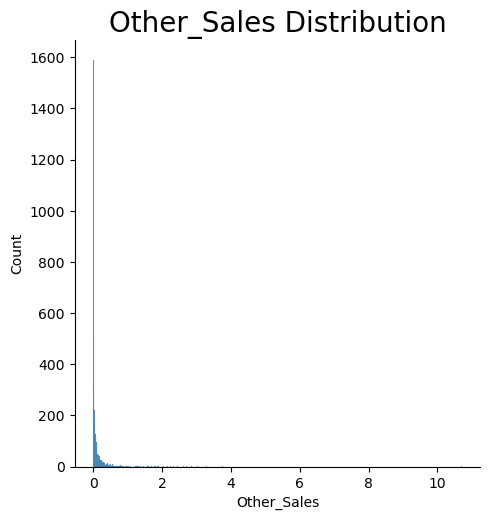

<Figure size 1800x1000 with 0 Axes>

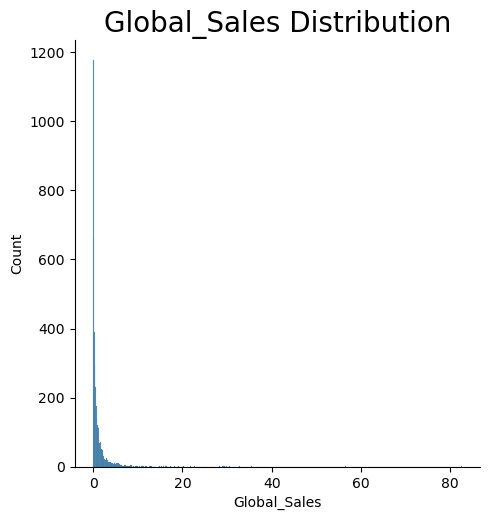

<Figure size 1800x1000 with 0 Axes>

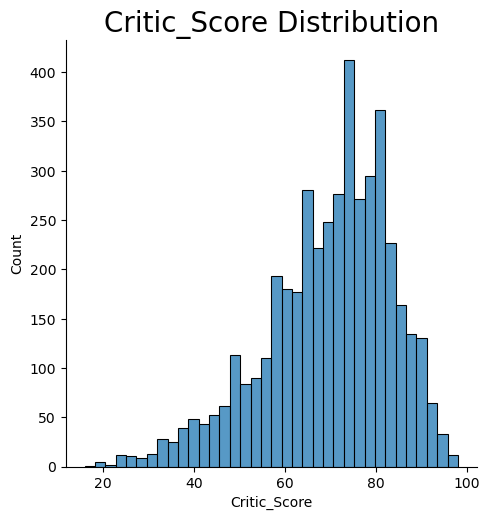

<Figure size 1800x1000 with 0 Axes>

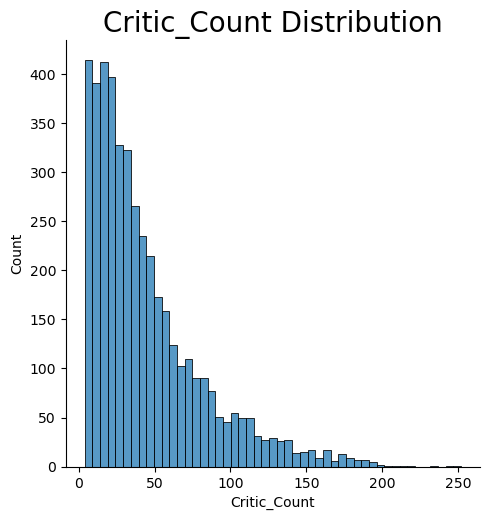

<Figure size 1800x1000 with 0 Axes>

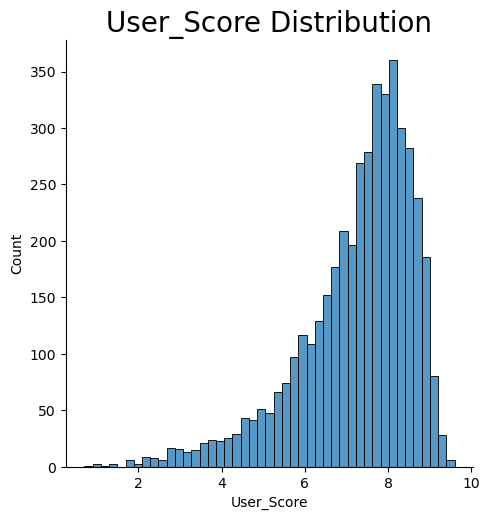

<Figure size 1800x1000 with 0 Axes>

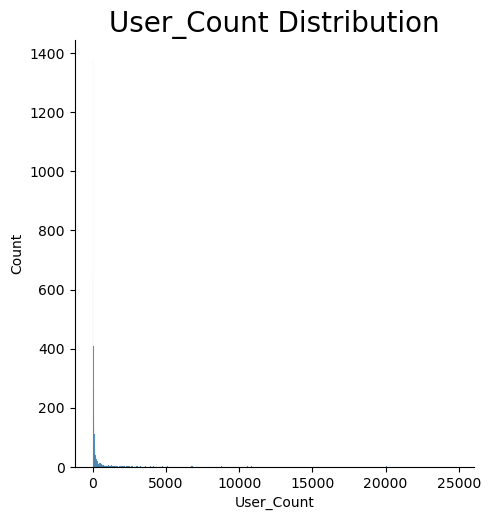

In [1932]:
numeric_features = ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score'
                   , 'Critic_Count' , 'User_Score' , 'User_Count']
for feature in numeric_features:
    plt.figure(figsize=(18, 10), facecolor='w')
    sns.displot(df[feature])
    plt.title('{} Distribution'.format(feature), fontsize=20)
    plt.show()

Looking at these graphs we can conclude 
- Years of Release , Critic Score and user score have a right skewness distribution 
- NA Sales, EU Sales, JP Sales, Other Sales and User Count have a very dispersed distribution 
- Critic Count has a left skewness distribution 

### Categorial Data

<Figure size 1800x1000 with 0 Axes>

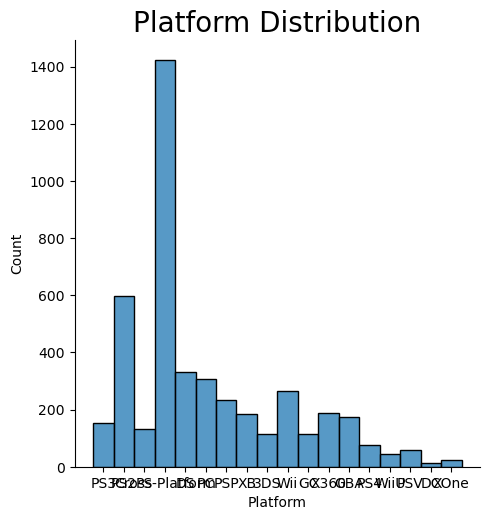

<Figure size 1800x1000 with 0 Axes>

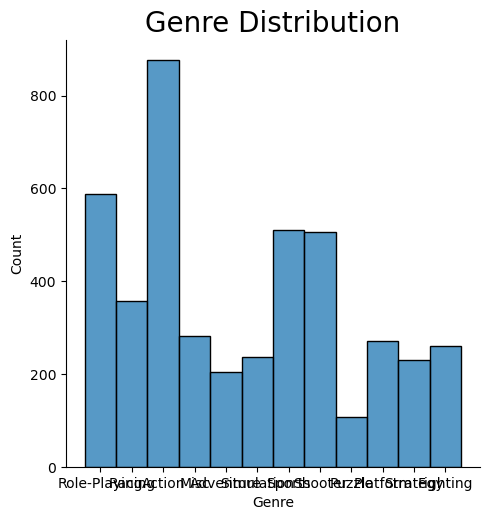

<Figure size 1800x1000 with 0 Axes>

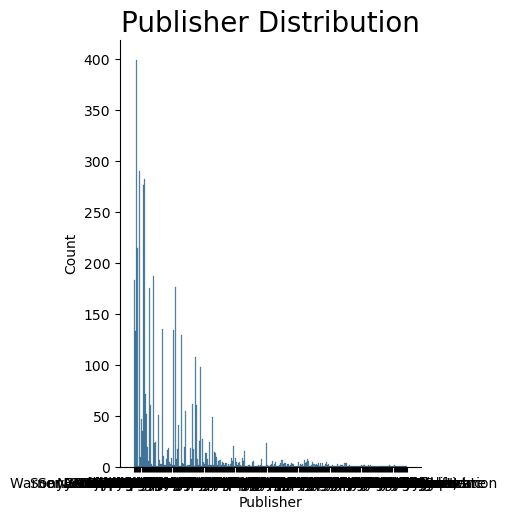

<Figure size 1800x1000 with 0 Axes>

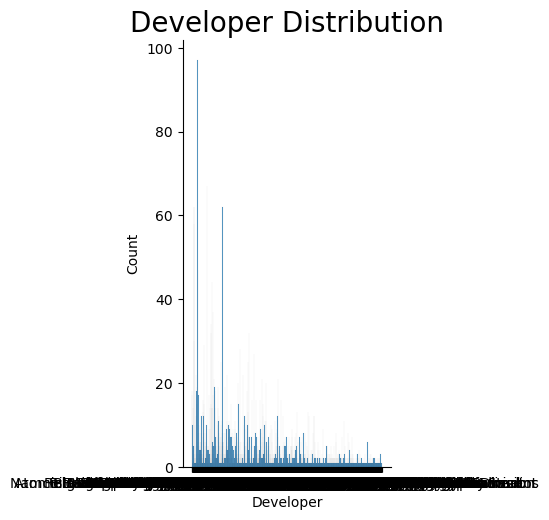

<Figure size 1800x1000 with 0 Axes>

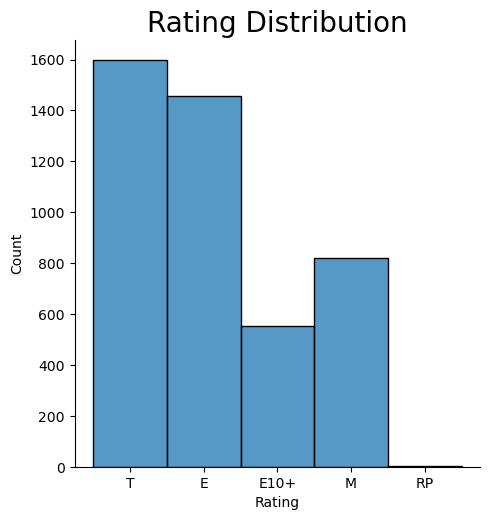

In [1935]:
categorical_columns = ["Platform", "Genre", "Publisher", "Developer", "Rating"]
for feature in categorical_columns:
    plt.figure(figsize=(18, 10), facecolor='w')
    sns.displot(df[feature])
    plt.title('{} Distribution'.format(feature), fontsize=20)
    plt.show()

From looking at these graphs we can conclude 
- Platform , Genre, and Rating have a uneven distribution 
- Publisher and Developer have a disparsed distribution 

## Bivariate Analysis

### Comparing Platforms to their average Global Sales

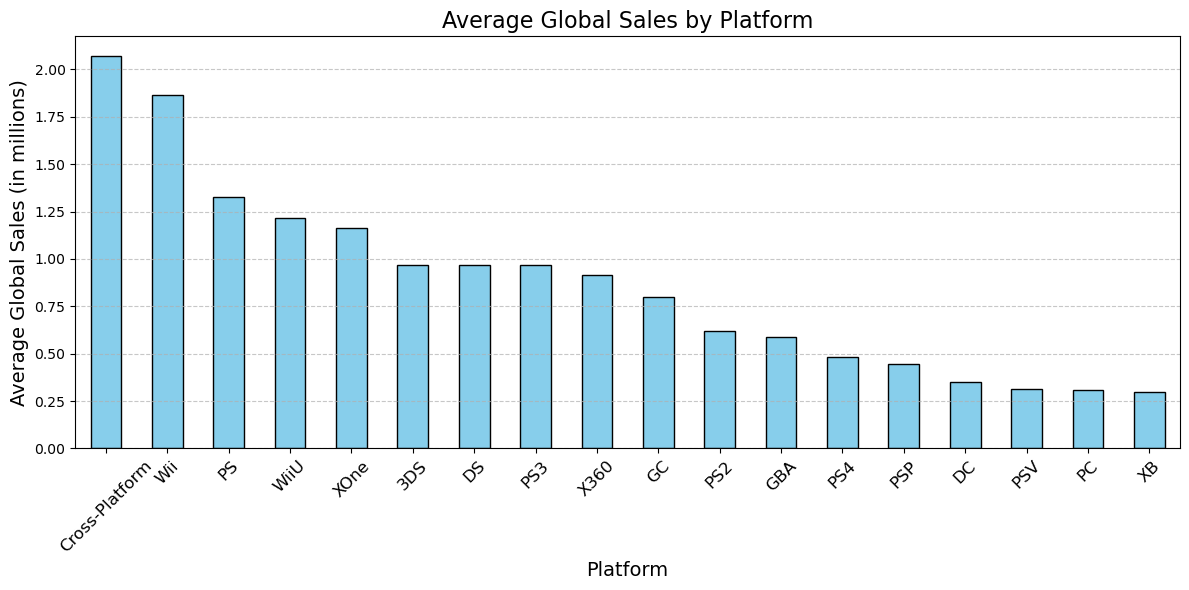

In [1939]:
# Step 1: Group by the original 'Platform' column and calculate averages
platform_averages = df.groupby("Platform")["Global_Sales"].mean().sort_values(ascending=False)

# Step 2: Plot the bar chart for average global sales
plt.figure(figsize=(12, 6))
platform_averages.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Global Sales by Platform", fontsize=16)
plt.xlabel("Platform", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


- From looking at the graph, Cross-Platform games have the highest average global sales, which makes sense as a game would earn more profit from being sold for multiple platforms

### Comparing Publishers to average Global Sales

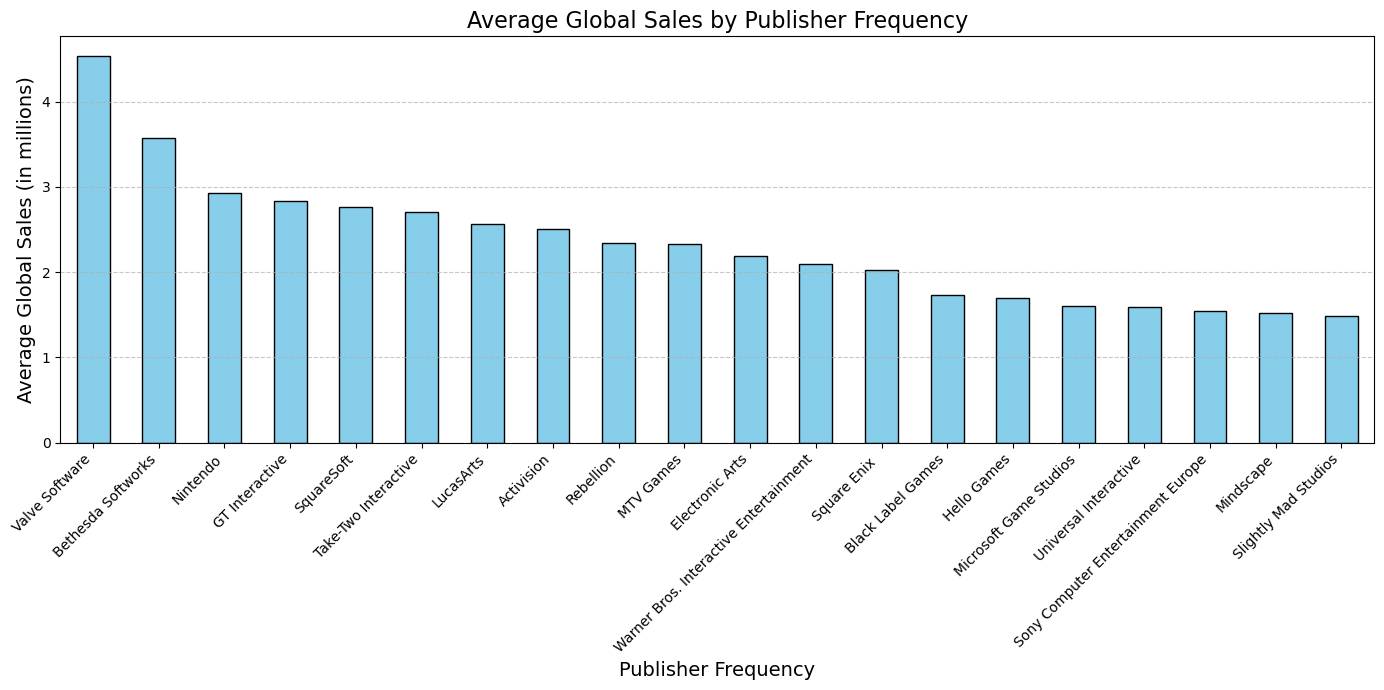

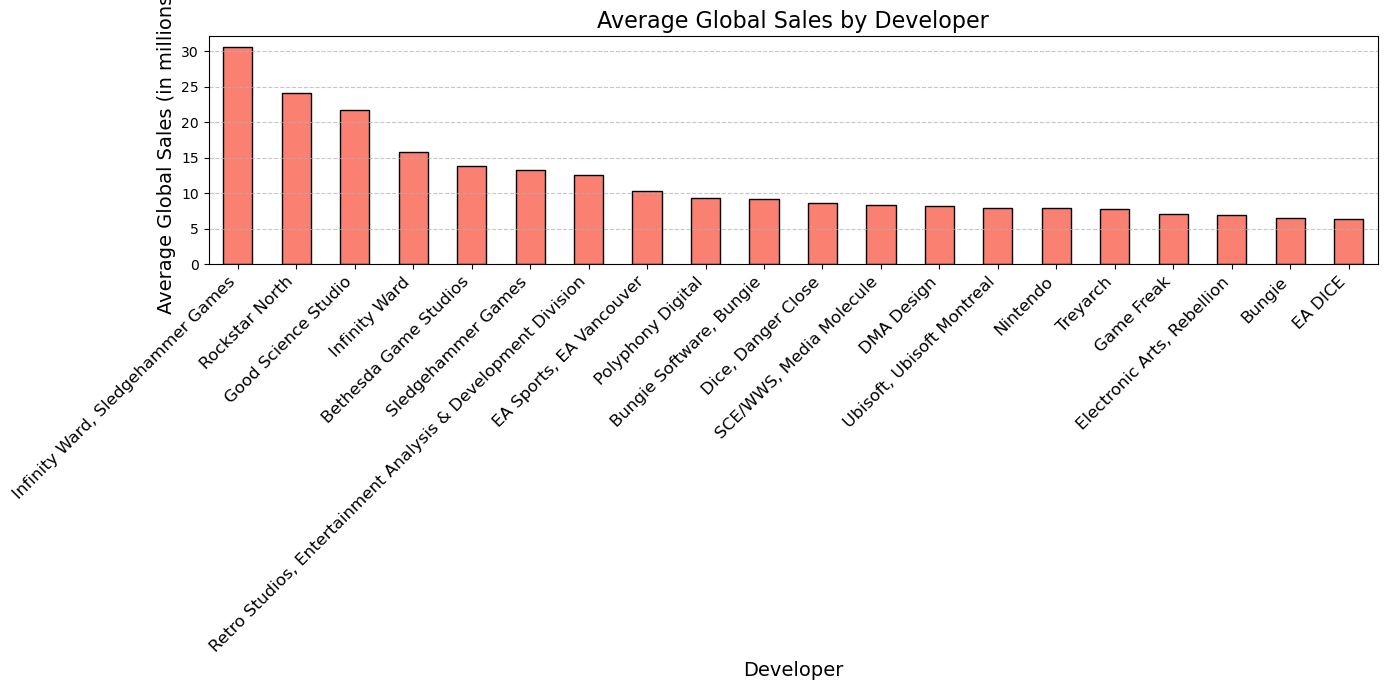

In [1942]:
# Step 1: Group by 'Publisher_freq' and calculate average global sales
publisher_avg_sales = (
    df.groupby("Publisher")["Global_Sales"].mean().sort_values(ascending=False)
)

# Step 2: Plot the bar chart for publisher frequencies
plt.figure(figsize=(14, 7))
publisher_avg_sales.head(20).plot(
    kind="bar", color="skyblue", edgecolor="black"
)  # Limit to top 20 for readability
plt.title("Average Global Sales by Publisher Frequency", fontsize=16)
plt.xlabel("Publisher Frequency", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Adjust figure size and rotate x-axis labels for readability
plt.figure(figsize=(14, 7))
df.groupby("Developer")["Global_Sales"].mean().sort_values(ascending=False).head(
    20
).plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Average Global Sales by Developer", fontsize=16)
plt.xlabel("Developer", fontsize=14)
plt.ylabel("Average Global Sales (in millions)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate labels and align them
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

- Looking at the top 20 publishers in the dataset, GT Interactive and Squaresoft contritubute the most to global sales
- Looking at the top 20 developers in the dataset, Good Science Studio has the highest average global sales and contributes the most to the dataset
- Nearly half of the top 20 average global sales were from different developer studios working together.

### Comparing User Score vs Global Sales & Critic Score vs Global Sales

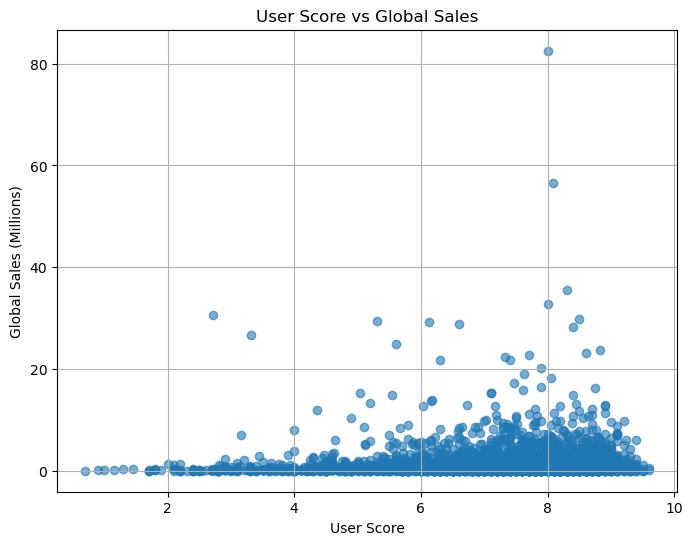

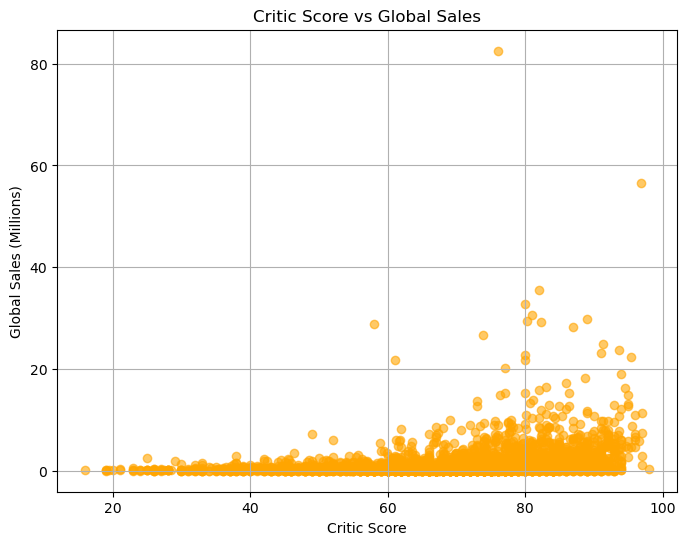

In [1945]:
# Scatter plot for User_Score vs Global_Sales
plt.figure(figsize=(8, 6))
plt.scatter(df["User_Score"], df["Global_Sales"], alpha=0.6)
plt.title("User Score vs Global Sales")
plt.xlabel("User Score")
plt.ylabel("Global Sales (Millions)")
plt.grid()
plt.show()

# Scatter plot for Critic_Score vs Global_Sales
plt.figure(figsize=(8, 6))
plt.scatter(df["Critic_Score"], df["Global_Sales"], alpha=0.6, color="orange")
plt.title("Critic Score vs Global Sales")
plt.xlabel("Critic Score")
plt.ylabel("Global Sales (Millions)")
plt.grid()
plt.show()

By looking at User Score vs Global Sales graphs we can conclude 
- Most of the data points are concentrated at lower global sales, regardless of user score. This suggests that the majority of products (likely games, based on the axes) achieve relatively modest sales figures
- There are a few outliers with extremely high global sales (above 40 million). These likely represent exceptionally successful products with high popularity which would make them outliers
- Sales do not strongly increase with User Score beyond a certain point. Products with user scores around 7–10 tend to have the highest sales outliers, but many others with similar scores have very low sales
- There is a dense cluster of products with moderate User Scores (5–8) and low sales (below 10 million). This indicates that many products perform adequately. Products with low User Scores (below 4) generally have lower sales

By looking at Critic Score vs Global Sales graphs we can conclude 
- There is a general trend where higher Critic Scores are associated with higher global sales. Products with Critic Scores above 70 are more 
likely to have high sales
- A few outliers with very high global sales (above 40 million) stand out. Most of these outliers also have Critic Scores above 80
- Products with low Critic Scores (below 40) generally have low global sales
- There is a high density of products with Critic Scores between 60 and 80 and sales below 10 million, suggesting that many products perform moderately well
- Products with Critic Scores above 80 seem to have better chances of achieving significant sales. There are still many with moderate sales in this range


Critic Score and User Score have a overall very similiar distribution with some outliars. Since users and critics overall agree on what games are generally good, it will be helpful to predict which ones will sell well as generally good games tend to sell more

## Multivariate Analysis

### User Score and Critic Score vs Global Sales

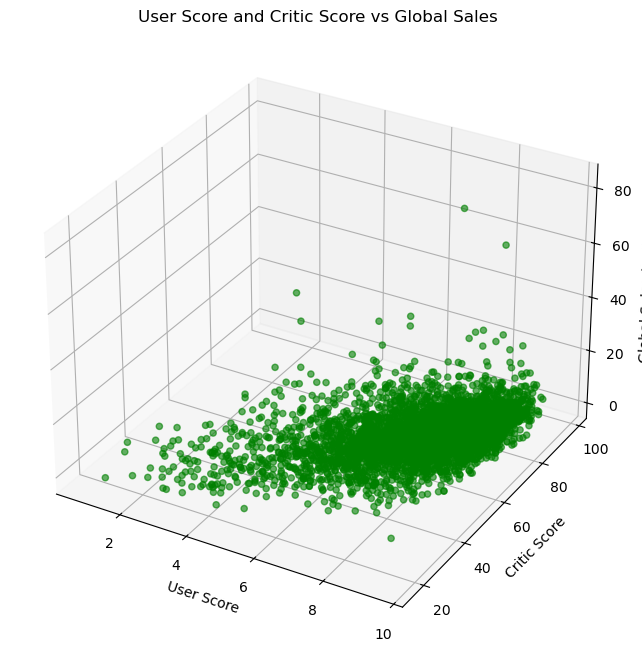

              User_Score  Critic_Score  Global_Sales
User_Score      1.000000      0.630118      0.054913
Critic_Score    0.630118      1.000000      0.252343
Global_Sales    0.054913      0.252343      1.000000


In [1951]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# 3D Scatter Plot
ax.scatter(
    encoded_df["User_Score"], encoded_df["Critic_Score"], encoded_df["Global_Sales"], c="green", alpha=0.6
)
ax.set_title("User Score and Critic Score vs Global Sales")
ax.set_xlabel("User Score")
ax.set_ylabel("Critic Score")
ax.set_zlabel("Global Sales (Millions)")
plt.show()

# Correlation matrix
correlation = df[["User_Score", "Critic_Score", "Global_Sales"]].corr()

print(correlation)

By looking at these graphs we can conclude 
- In general higher user score also coincides with higher critic score which results in global sales to increase for higher
scores
-  A large cluster of data points exists where both User Scores and Critic Scores are in the mid-to-high range (approximately 6–10 for User Score and 50–80 for Critic Score). This suggests many products with moderate to high sales tend to receive positive scores from both users and critics
-  There are a few data points with very high Global Sales that are separated from the dense cluster. These are likely representing successful products, possibly independent of user or critic scores which would make them outliers
-  Data points are spread across a wide range of User and Critic Scores, but higher sales seem more frequent at higher scores

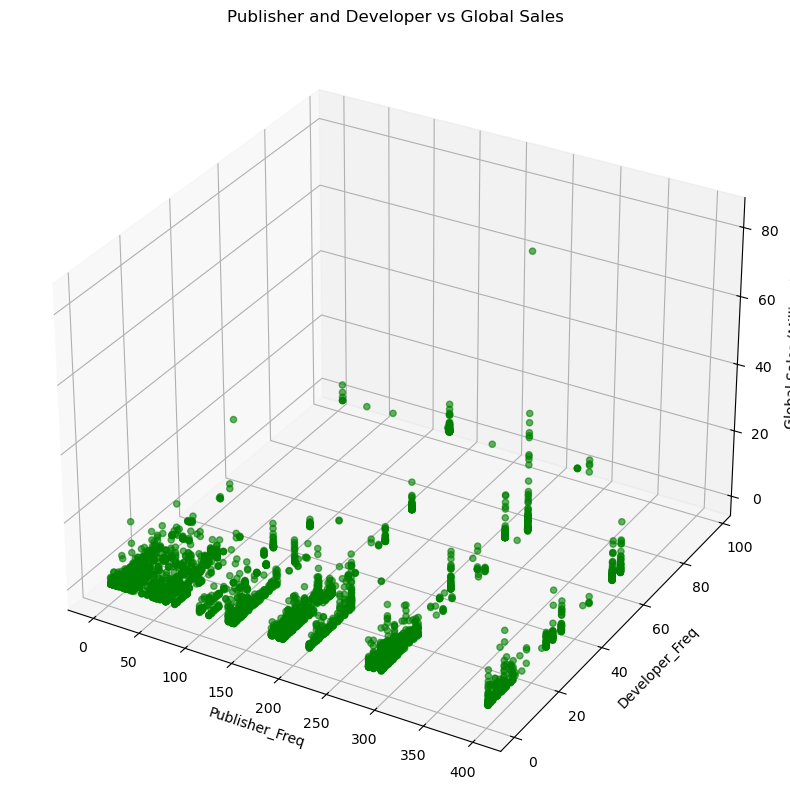

                Publisher_Freq  Developer_Freq  Global_Sales
Publisher_Freq        1.000000        0.275601      0.200174
Developer_Freq        0.275601        1.000000      0.154912
Global_Sales          0.200174        0.154912      1.000000


In [1953]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# 3D Scatter Plot
ax.scatter(
    encoded_df["Publisher_Freq"], encoded_df["Developer_Freq"], encoded_df["Global_Sales"], c="green", alpha=0.6
)
ax.set_title("Publisher and Developer vs Global Sales")
ax.set_xlabel("Publisher_Freq")
ax.set_ylabel("Developer_Freq")
ax.set_zlabel("Global Sales (Millions)")
plt.show()

# Correlation matrix
correlation = encoded_df[["Publisher_Freq", "Developer_Freq", "Global_Sales"]].corr()

print(correlation)

- Established Publishers Dominate: Publishers with a high number of releases tend to see more consistent sales, showing the advantage of strong brand recognition and a loyal player base.
- Most Games Stay Small: A big chunk of games sell under a million copies, which highlights how tough it is for most titles to break into the big leagues.
- Blockbusters Are Rare: The few games with massive sales really stand out, showing how success in the gaming world often depends on a few big hits rather than steady performance across all releases.
- Developers Don’t Always Drive Sales: While developers matter, the data suggests publishers and their marketing muscle might play a bigger role in pushing games to higher sales.

## Eliminating Data Leakage Before Feature Selection and Model Training

In [1956]:
columns_to_drop = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
encoded_df = encoded_df.drop(columns=columns_to_drop)

- NA_Sales, EU_Sales, JP_Sales, and Other_Sales are dropped because their values add up to Global sales and keeping their data in the dataframe will lead to target leakage, as these features are direct components of Global Sales. 

## Feature Selection

In [1959]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
import pandas as pd
import numpy as np

# Step 1: Create a copy of encoded_df and drop the Name column
processed_df = encoded_df.copy()
processed_df.drop(columns=["Name"], inplace=True)

# Step 2: Filter for numeric columns
numerical_data = processed_df.select_dtypes(include=[np.number])

# Step 3: Remove features with low variance
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)

# Fit the VarianceThreshold to the numerical data
selector.fit(numerical_data)

# Get low-variance features
low_variance_features = numerical_data.columns[~selector.get_support()]
numerical_high_variance = numerical_data.drop(columns=low_variance_features)
print(f"Removed low-variance features: {list(low_variance_features)}")

# Step 5: Statistical Feature Selection (F-score)
X = numerical_uncorrelated.drop(columns=["Global_Sales"], errors='ignore')
y = numerical_uncorrelated["Global_Sales"]

select_k_best = SelectKBest(score_func=f_regression, k=7)
X_selected_kbest = select_k_best.fit_transform(X, y)

selected_features_kbest = X.columns[select_k_best.get_support()]
print(f"Top features based on F-score: {list(selected_features_kbest)}")

# Step 6: Feature Importance using Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_rf_features = feature_importances.head(10)["Feature"].tolist()
print(f"Top features based on Random Forest importance: {top_rf_features}")

# Step 7: Combine results
final_selected_features = set(selected_features_kbest).union(top_rf_features)
final_selected_features = [col for col in final_selected_features if col in numerical_uncorrelated.columns]  # Ensure validity

# Print the final selected features
print("Final selected features:")
print(final_selected_features)


Removed low-variance features: []
Top features based on F-score: ['Year_of_Release', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Publisher_Freq', 'Developer_Freq']
Top features based on Random Forest importance: ['User_Count', 'Critic_Count', 'Developer_Freq', 'Critic_Score', 'Year_of_Release', 'User_Score', 'Publisher_Freq']
Final selected features:
['Developer_Freq', 'Critic_Count', 'Critic_Score', 'User_Count', 'Publisher_Freq', 'Year_of_Release', 'User_Score']


### Explanation of Feature Selection Results

- **Low-Variance Features Removed**: No features were removed due to low variance.

- **Top Features Based on F-Score**: The most relevant features based on F-Score were determined as:
  - `Year_of_Release`
  - `Critic_Score`
  - `Critic_Count`
  - `User_Score`
  - `User_Count`
  - `Publisher_Freq`
  - `Developer_Freq`

- **Top Features from Random Forest Importance**: Used a Random Forest to determine feature importance, with `User_Count`, `Critic_Score`, and `Developer_Freq` being ranked as highly significant.

- **Final Selected Features**: After combining insights from the above methods, the final set of features includes:
  - `Developer_Freq`
  - `Critic_Count`
  - `Critic_Score`
  - `User_Count`
  - `Publisher_Freq`
  - `Year_of_Release`
  - `User_Score`


- Going into training the models, we want to see how the models do with all the features versus only using the features we found using feature selection

Here we use feature scaling our features in order to normalize the range of features in the data set 

# Training Models on Feature Selected Data

In [1788]:
from sklearn.model_selection import train_test_split

# Define the feature matrix X and target variable y
X = encoded_df[final_selected_features]  # Only the selected features (no target column)
y = encoded_df["Global_Sales"]  # Extract the target column

train_x, test_x, train_y, test_y = train_test_split(X,y,
    test_size=0.2,
    random_state=1,
)

In [1789]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

### Linear Regression

In [1791]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model on the scaled training data
linear_regressor.fit(train_x, train_y)

# Make predictions on the scaled test data
predictions = linear_regressor.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, predictions)

# Print evaluation metrics
print("=== Linear Regression Evaluation ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

=== Linear Regression Evaluation ===
Mean Absolute Error (MAE): 1.0449
Mean Squared Error (MSE): 5.5861
Root Mean Squared Error (RMSE): 2.3635
R-squared (R2 Score): 0.2026


### Decision Tree Regression

In [1793]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
tree_regressor.fit(train_x, train_y)

# Make predictions on the test data
tree_predictions = tree_regressor.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, tree_predictions)
mse = mean_squared_error(test_y, tree_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, tree_predictions)

# Print evaluation metrics
print("=== Decision Tree Regression Evaluation ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

=== Decision Tree Regression Evaluation ===
Mean Absolute Error (MAE): 1.1783
Mean Squared Error (MSE): 10.1031
Root Mean Squared Error (RMSE): 3.1785
R-squared (R2 Score): -0.4422


### K-Nearest Neighbors Regression

In [1795]:
from sklearn.neighbors import KNeighborsRegressor

# Set up the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Default k = 5 (number of neighbors)

# Fit the model on the training data
knn.fit(train_x, train_y)

# Predict on the test set
knn_predictions = knn.predict(test_x)

# Evaluate the model
knn_mae = mean_absolute_error(test_y, knn_predictions)
knn_mse = mean_squared_error(test_y, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(test_y, knn_predictions)

# Print the evaluation metrics
print("=== K-Nearest Neighbor Regression ===")
print(f"Mean Absolute Error (MAE): {knn_mae:.4f}")
print(f"Mean Squared Error (MSE): {knn_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {knn_rmse:.4f}")
print(f"R-squared (R2 Score): {knn_r2:.4f}")

=== K-Nearest Neighbor Regression ===
Mean Absolute Error (MAE): 0.9328
Mean Squared Error (MSE): 5.3831
Root Mean Squared Error (RMSE): 2.3202
R-squared (R2 Score): 0.2315


### Random Forest Regression

In [1797]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Set up the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators is the number of trees

# Fit the model on the training data
rf.fit(train_x, train_y)

# Predict on the test set
rf_predictions = rf.predict(test_x)

# Evaluate the model
rf_mae = mean_absolute_error(test_y, rf_predictions)
rf_mse = mean_squared_error(test_y, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(test_y, rf_predictions)

# Print the evaluation metrics
print("=== Random Forest Regression ===")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"R-squared (R2 Score): {rf_r2:.4f}")

=== Random Forest Regression ===
Mean Absolute Error (MAE): 0.9617
Mean Squared Error (MSE): 6.0696
Root Mean Squared Error (RMSE): 2.4637
R-squared (R2 Score): 0.1336


### Gradient Boosting Regression

In [1799]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit the model on the training data
gbr.fit(train_x, train_y)

# Predict on the test set
gbr_predictions = gbr.predict(test_x)

# Evaluate the model
gbr_mae = mean_absolute_error(test_y, gbr_predictions)
gbr_mse = mean_squared_error(test_y, gbr_predictions)
gbr_rmse = np.sqrt(gbr_mse)
gbr_r2 = r2_score(test_y, gbr_predictions)

# Print the evaluation metrics
print("=== Gradient Boosting Regression ===")
print(f"Mean Absolute Error (MAE): {gbr_mae:.4f}")
print(f"Mean Squared Error (MSE): {gbr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {gbr_rmse:.4f}")
print(f"R-squared (R2 Score): {gbr_r2:.4f}")


=== Gradient Boosting Regression ===
Mean Absolute Error (MAE): 0.8922
Mean Squared Error (MSE): 4.5468
Root Mean Squared Error (RMSE): 2.1323
R-squared (R2 Score): 0.3509


### Support Vector Regression

In [1801]:
# Import necessary libraries
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Support Vector Regressor (SVR)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can adjust kernel, C, and epsilon as needed

# Fit the model on the training data
svr.fit(train_x, train_y)

# Predict on the test set
svr_predictions = svr.predict(test_x)

# Evaluate the model
svr_mae = mean_absolute_error(test_y, svr_predictions)
svr_mse = mean_squared_error(test_y, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(test_y, svr_predictions)

# Print the evaluation metrics
print("=== Support Vector Regression (SVR) ===")
print(f"Mean Absolute Error (MAE): {svr_mae:.4f}")
print(f"Mean Squared Error (MSE): {svr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {svr_rmse:.4f}")
print(f"R-squared (R2 Score): {svr_r2:.4f}")


=== Support Vector Regression (SVR) ===
Mean Absolute Error (MAE): 0.8062
Mean Squared Error (MSE): 5.2757
Root Mean Squared Error (RMSE): 2.2969
R-squared (R2 Score): 0.2469


### Observations from Model Evaluations

- **Linear Regression**:
  - Performed poorly with a low \( R^2 \) score (0.2026), indicating it struggles to capture the variance in the data.
  - Relatively high error metrics (MAE: 1.0449, RMSE: 2.3635) suggest the model is not able to capture complex non-linear patterns.

- **Decision Tree Regression**:
  - Worst-performing model with a negative \( R^2 \) score (-0.4422), meaning it performs worse than a simple mean prediction.
  - High RMSE (3.1785) and MAE (1.1783) indicate instability and potential overfitting to the training data.

- **K-Nearest Neighbor Regression**:
  - Performed better than Linear Regression and Decision Tree with an \( R^2 \) score of 0.2315.
  - Moderate error metrics (MAE: 0.9328, RMSE: 2.3202) suggest it captures some local patterns but struggles with larger trends.

- **Random Forest Regression**:
  - Performance was weaker than expected with an \( R^2 \) score of 0.1336, indicating it didn't generalize well.
  - Slightly higher error metrics (MAE: 0.9617, RMSE: 2.4637) compared to K-Nearest Neighbors, suggesting it may require further tuning or better feature selection.

- **Gradient Boosting Regression**:
  - Best-performing model with the highest \( R^2 \) score (0.3509) among all models.
  - Achieved the lowest RMSE (2.1323) and relatively low MAE (0.8922), indicating it captures both linear and non-linear relationships better than other models.

- **Support Vector Regression (SVR)**:
  - Performed well with the lowest MAE (0.8062) but a moderate \( R^2 \) score (0.2469).
  - Relatively low RMSE (2.2969) suggests it fits specific relationships well but struggles with large-scale variance.

# Testing the Models on All Features

In [2019]:
from sklearn.model_selection import train_test_split

# Define the feature matrix X and target variable y
X = encoded_df.drop(columns=["Name", "Global_Sales"], axis=1)  # Removing name as it is the ID Label in the data set and the target variable
y = encoded_df["Global_Sales"]  # Extract the target column

train_x, test_x, train_y, test_y = train_test_split(X,y,
    test_size=0.2,
    random_state=1,
)

In [1997]:
# Scaling the Data
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

### Linear Regression

In [2003]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model on the scaled training data
linear_regressor.fit(train_x, train_y)

# Make predictions on the scaled test data
predictions = linear_regressor.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, predictions)

# Print evaluation metrics
print("=== Linear Regression Evaluation ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

=== Linear Regression Evaluation ===
Mean Absolute Error (MAE): 1.0581
Mean Squared Error (MSE): 5.3614
Root Mean Squared Error (RMSE): 2.3155
R-squared (R2 Score): 0.2346


### Decision Tree Regression

In [2005]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
tree_regressor.fit(train_x, train_y)

# Make predictions on the test data
tree_predictions = tree_regressor.predict(test_x)

# Evaluate the model
mae = mean_absolute_error(test_y, tree_predictions)
mse = mean_squared_error(test_y, tree_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, tree_predictions)

# Print evaluation metrics
print("=== Decision Tree Regression Evaluation ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

=== Decision Tree Regression Evaluation ===
Mean Absolute Error (MAE): 0.9389
Mean Squared Error (MSE): 5.8728
Root Mean Squared Error (RMSE): 2.4234
R-squared (R2 Score): 0.1616


### K-Nearest Neighbors Regression

In [2009]:
from sklearn.neighbors import KNeighborsRegressor

# Set up the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # Default k = 5 (number of neighbors)

# Fit the model on the training data
knn.fit(train_x, train_y)

# Predict on the test set
knn_predictions = knn.predict(test_x)

# Evaluate the model
knn_mae = mean_absolute_error(test_y, knn_predictions)
knn_mse = mean_squared_error(test_y, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(test_y, knn_predictions)

# Print the evaluation metrics
print("=== K-Nearest Neighbor Regression ===")
print(f"Mean Absolute Error (MAE): {knn_mae:.4f}")
print(f"Mean Squared Error (MSE): {knn_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {knn_rmse:.4f}")
print(f"R-squared (R2 Score): {knn_r2:.4f}")

=== K-Nearest Neighbor Regression ===
Mean Absolute Error (MAE): 0.9843
Mean Squared Error (MSE): 5.9213
Root Mean Squared Error (RMSE): 2.4334
R-squared (R2 Score): 0.1547


### Random Forest Regression

In [2011]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Set up the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators is the number of trees

# Fit the model on the training data
rf.fit(train_x, train_y)

# Predict on the test set
rf_predictions = rf.predict(test_x)

# Evaluate the model
rf_mae = mean_absolute_error(test_y, rf_predictions)
rf_mse = mean_squared_error(test_y, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(test_y, rf_predictions)

# Print the evaluation metrics
print("=== Random Forest Regression ===")
print(f"Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"Mean Squared Error (MSE): {rf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"R-squared (R2 Score): {rf_r2:.4f}")

=== Random Forest Regression ===
Mean Absolute Error (MAE): 0.8139
Mean Squared Error (MSE): 4.1400
Root Mean Squared Error (RMSE): 2.0347
R-squared (R2 Score): 0.4090


### Gradient Boosting Regression

In [2013]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit the model on the training data
gbr.fit(train_x, train_y)

# Predict on the test set
gbr_predictions = gbr.predict(test_x)

# Evaluate the model
gbr_mae = mean_absolute_error(test_y, gbr_predictions)
gbr_mse = mean_squared_error(test_y, gbr_predictions)
gbr_rmse = np.sqrt(gbr_mse)
gbr_r2 = r2_score(test_y, gbr_predictions)

# Print the evaluation metrics
print("=== Gradient Boosting Regression ===")
print(f"Mean Absolute Error (MAE): {gbr_mae:.4f}")
print(f"Mean Squared Error (MSE): {gbr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {gbr_rmse:.4f}")
print(f"R-squared (R2 Score): {gbr_r2:.4f}")


=== Gradient Boosting Regression ===
Mean Absolute Error (MAE): 0.8536
Mean Squared Error (MSE): 4.2026
Root Mean Squared Error (RMSE): 2.0500
R-squared (R2 Score): 0.4001


### Support Vector Regression

In [2015]:
# Import necessary libraries
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the Support Vector Regressor (SVR)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # You can adjust kernel, C, and epsilon as needed

# Fit the model on the training data
svr.fit(train_x, train_y)

# Predict on the test set
svr_predictions = svr.predict(test_x)

# Evaluate the model
svr_mae = mean_absolute_error(test_y, svr_predictions)
svr_mse = mean_squared_error(test_y, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(test_y, svr_predictions)

# Print the evaluation metrics
print("=== Support Vector Regression (SVR) ===")
print(f"Mean Absolute Error (MAE): {svr_mae:.4f}")
print(f"Mean Squared Error (MSE): {svr_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {svr_rmse:.4f}")
print(f"R-squared (R2 Score): {svr_r2:.4f}")


=== Support Vector Regression (SVR) ===
Mean Absolute Error (MAE): 0.8497
Mean Squared Error (MSE): 5.6161
Root Mean Squared Error (RMSE): 2.3698
R-squared (R2 Score): 0.1983


### Observations from Model Evaluations

- **Linear Regression**:
  - Performed poorly with the lowest \( R^2 \) score (0.2414) among the models.
  - High error metrics (MAE: 1.0579, RMSE: 2.3052) suggest it struggles to capture non-linear relationships in the data.

- **Decision Tree Regression**:
  - Slightly better MAE (0.9401) compared to Linear Regression, but lower \( R^2 \) (0.1662).
  - Indicates overfitting or instability due to its non-linear nature with high variance.

- **K-Nearest Neighbor Regression**:
  - Achieved better balance with \( R^2 = 0.3137 \) and lowest MAE (0.8922) among non-ensemble models.
  - Indicates strong local modeling but still limited by lack of global data understanding.

- **Random Forest Regression**:
  - Best-performing model with the highest \( R^2 \) score (0.4062) and lowest RMSE (2.0395).
  - Ensemble approach effectively captures both linear and non-linear patterns in the data.

- **Gradient Boosting Regression**:
  - Close performance to Random Forest (\( R^2 = 0.3978 \)) but slightly higher error metrics.
  - Works well for complex data but may require fine-tuning for optimal results.

- **Support Vector Regression (SVR)**:
  - Achieved the lowest MAE (0.7622) but moderate \( R^2 \) (0.2957).
  - Indicates its ability to fit specific relationships but may struggle with larger-scale trends in the data.

### Conclusion
- Feature Selection had a lower score across all models and didn't improve the R^2. We will keep the features when doing Hyperparameter Tuning and Ensembling


## Hyperparameter Tuning

In [1864]:
# Import necessary libraries
# DO NOT RERUN IF YOU DO NOT HAVE TO, TAKES AROUND 7-12 MINUTES
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
import numpy as np

# Define the models and their respective hyperparameter grids
param_grids = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf'],
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.2],
            'gamma': ['scale', 'auto']
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': list(range(1, 21)),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],
            'max_iter': [1000, 2000, 5000]
        }
    }
}

# Create a dictionary to store the best models and their scores
best_models = {}

# Perform GridSearchCV or RandomizedSearchCV for each model
for model_name, model_info in param_grids.items():
    print(f"=== Tuning {model_name} ===")
    
    # Initialize the search method (use RandomizedSearchCV for faster results)
    search = RandomizedSearchCV(
        estimator=model_info['model'], 
        param_distributions=model_info['params'], 
        n_iter=20, 
        scoring='r2', 
        cv=5, 
        verbose=2, 
        n_jobs=-1, 
        random_state=42
    )
    
    # Fit the model on the training data
    search.fit(train_x, train_y)
    
    # Store the best model and score
    best_models[model_name] = {
        'best_score': search.best_score_,
        'best_params': search.best_params_,
        'best_estimator': search.best_estimator_
    }
    
    print(f"Best Score for {model_name}: {search.best_score_}")
    print(f"Best Parameters for {model_name}: {search.best_params_}")
    print("\n" + "="*50 + "\n")

# Print summary of the best models
print("\n=== Best Model Summary ===\n")
for model_name, model_info in best_models.items():
    print(f"Model: {model_name}")
    print(f"Best R2 Score: {model_info['best_score']:.4f}")
    print(f"Best Parameters: {model_info['best_params']}")
    print("\n" + "-"*50 + "\n")


=== Tuning RandomForestRegressor ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score for RandomForestRegressor: 0.43544523996762435
Best Parameters for RandomForestRegressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


=== Tuning GradientBoostingRegressor ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score for GradientBoostingRegressor: 0.37681994749001535
Best Parameters for GradientBoostingRegressor: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}


=== Tuning SVR ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score for SVR: 0.36120525284448135
Best Parameters for SVR: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 100}


=== Tuning KNeighborsRegressor ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score for KNeighborsRegressor: 0.3504010229772133
Best Parameters for KNeighborsRegressor: {'weights': 'di

=== Best Model Summary ===

Model: RandomForestRegressor
Best R2 Score: 0.4354
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

--------------------------------------------------

Model: GradientBoostingRegressor
Best R2 Score: 0.3768
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}

--------------------------------------------------

Model: SVR
Best R2 Score: 0.3612
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 100}

--------------------------------------------------

Model: KNeighborsRegressor
Best R2 Score: 0.3504
Best Parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}

--------------------------------------------------

Model: Ridge
Best R2 Score: 0.2928
Best Parameters: {'solver': 'lsqr', 'max_iter': 1000, 'alpha': 100}

--------------------------------------------------


## Ensembling (Stacking)

In [2017]:
# Import necessary libraries
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the base models with their best hyperparameters
base_models = [
    ('random_forest', RandomForestRegressor(
        n_estimators=200, 
        min_samples_split=2, 
        min_samples_leaf=2, 
        max_depth=None, 
        random_state=42
    )),
    ('gradient_boosting', GradientBoostingRegressor(
        subsample=1.0, 
        n_estimators=200, 
        max_depth=3, 
        learning_rate=0.2, 
        random_state=42
    )),
    ('svr', SVR(
        kernel='rbf', 
        gamma='scale', 
        epsilon=0.1, 
        C=100
    )),
    ('knn', KNeighborsRegressor(
        weights='distance', 
        n_neighbors=3, 
        metric='manhattan'
    )),
    ('ridge', Ridge(
        solver='lsqr', 
        max_iter=1000, 
        alpha=100, 
        random_state=42
    ))
]

# Define the final estimator (can be any model, but Gradient Boosting often works well)
final_estimator = GradientBoostingRegressor(
    subsample=1.0, 
    n_estimators=200, 
    max_depth=3, 
    learning_rate=0.2, 
    random_state=42
)

# Set up the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    cv=5  # 5-fold cross-validation for better generalization
)

# Train the Stacking Regressor
stacking_regressor.fit(train_x, train_y)

# Make predictions on the test set
stacking_predictions = stacking_regressor.predict(test_x)

# Evaluate the model
stacking_mae = mean_absolute_error(test_y, stacking_predictions)
stacking_mse = mean_squared_error(test_y, stacking_predictions)
stacking_rmse = np.sqrt(stacking_mse)
stacking_r2 = r2_score(test_y, stacking_predictions)

# Print the evaluation metrics
print("=== Stacking Regressor Evaluation ===")
print(f"Mean Absolute Error (MAE): {stacking_mae:.4f}")
print(f"Mean Squared Error (MSE): {stacking_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {stacking_rmse:.4f}")
print(f"R-squared (R2 Score): {stacking_r2:.4f}")

=== Stacking Regressor Evaluation ===
Mean Absolute Error (MAE): 0.8216
Mean Squared Error (MSE): 4.0099
Root Mean Squared Error (RMSE): 2.0025
R-squared (R2 Score): 0.4276
